# TP1 - Parte B: Classificação de Atividades Humanas 
### Tópicos de Ciência dos Dados - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995


In [134]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

## 4.5 e 4.6 da Parte A

### 4.5. ReliefF

In [135]:
from ReliefF import ReliefF

def reliefF(x, y):
    fs = ReliefF(n_features_to_keep=10)
    fs.fit_transform(x, y)

    return fs.top_features[:10]

### 4.6. Fisher Score

In [136]:
from skfeature.function.similarity_based import fisher_score

def fisherScore(x, y):
    return fisher_score.fisher_score(x, y)

## Parte B


### 1.1. Data Splitting

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

In [137]:
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

def train_test(data, target, train_size):

    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size)

    trainTest = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]}

    return trainTest

def train_validation_test(data, target, train_size, test_size):

    x_train, x_rem, y_train, y_rem = train_test_split(data, target, train_size=train_size)

    # 1 - train_size -> correponde agora ao nosso 100%(1)
    # test_size -> test_size / (1-train_size)

    test = test_size / (1-train_size)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = test)

    trainValidation = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test], "VALIDATION": [x_valid, y_valid]}
    
    return trainValidation



### 1.1.2. K-fold data split

In [138]:
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

def k_fold(x, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle = True)
    kfold = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kfold.append({"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]})
    
    return kfold

In [139]:
#Testes
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

print("--Train Test--\n")
trainTest = train_test(X, y, 0.7)
display(trainTest)

print("\n--Train Validation Test--\n")
trainValidation = train_validation_test(X, y, 0.4, 0.3)
display(trainValidation)

print("\n--K Fold--\n")
kFold = k_fold(X, y, 4)
display(kFold)

--Train Test--



{'TRAIN': [array([[3, 4],
         [1, 2]]),
  array([2, 1])],
 'TEST': [array([[3, 4],
         [1, 2]]),
  array([4, 3])]}


--Train Validation Test--



{'TRAIN': [array([[1, 2]]), array([3])],
 'TEST': [array([[3, 4],
         [1, 2]]), array([2, 1])],
 'VALIDATION': [array([[3, 4]]), array([4])]}


--K Fold--



[{'TRAIN': [array([[3, 4],
          [1, 2],
          [3, 4]]),
   array([2, 3, 4])],
  'TEST': [array([[1, 2]]), array([1])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [3, 4]]),
   array([1, 2, 4])],
  'TEST': [array([[1, 2]]), array([3])]},
 {'TRAIN': [array([[1, 2],
          [1, 2],
          [3, 4]]),
   array([1, 3, 4])],
  'TEST': [array([[3, 4]]), array([2])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [1, 2]]),
   array([1, 2, 3])],
  'TEST': [array([[3, 4]]), array([4])]}]

### 1.2. Métricas de exactidação

In [140]:
#Teste
true = [2, 0, 2, 2, 0, 1]
pred = [0, 0, 2, 2, 0, 2]

-> Explicação do parâmetro average

**'binary'**:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

**'micro'**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

**'macro'**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**'weighted'**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**'samples'**:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

Confusion Matrix:
 [[2 0 0]
 [0 0 1]
 [1 0 2]]

Recall:  0.5555555555555555

Precision:  0.4444444444444444

F1-score:  0.48888888888888893
--------------------------------------------------


,Metrics
Recall,0.555556
Precision,0.444444
F1-score,0.488889


,0,1,2
0,2,0,0
1,0,0,1
2,1,0,2


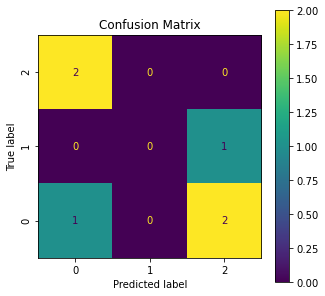

In [141]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import precision_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

def metrics(true, pred, printar = False):
    cm = confusion_matrix(true, pred)
    rs = recall_score(true, pred, average='macro', zero_division=0)
    ps = precision_score(true, pred, average='macro', zero_division=0)
    f1 = f1_score(true, pred, average='macro', zero_division=0)

    if(printar):
        print('Confusion Matrix:\n', cm)
        print('\nRecall: ', rs)
        print('\nPrecision: ', ps)
        print('\nF1-score: ', f1)
        print('-'*50)

    return [cm, rs, ps, f1]

def mais_bonito(cm, rs, ps, f1, labels):

    metricsFrame = pd.DataFrame([rs, ps, f1], columns=['Metrics']).rename(index={0: 'Recall', 1: 'Precision', 2: 'F1-score'})
    display(metricsFrame)
    
    cmFrame = pd.DataFrame(cm, columns=labels, index=labels).style.set_caption("Confusion Matrix")
    display(cmFrame)

    cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
    _, ax = plt.subplots(figsize=(5,5))
    cmp.plot(ax=ax)
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels[::-1], rotation=90)
    plt.show()
    

cm, rs, ps, f1 = metrics(true, pred, True)
mais_bonito(cm, rs, ps, f1, [0,1,2])



### 2.1. Dataset

In [142]:
iris = datasets.load_iris()

data = iris.data
target = iris.target

display(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

### 2.1. k-Nearest Neighbours

In [143]:
from sklearn.neighbors import KNeighborsClassifier

def K_neighbors_classifier(x, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x, y)

    return neigh

neigh_teste = K_neighbors_classifier(data, target, 1)

### 2.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


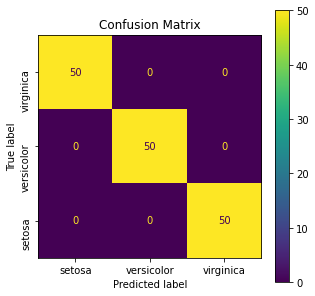

In [144]:
def TO_211(x, y, labels, k):
    neigh = K_neighbors_classifier(x, y, k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TO_211(data, target, iris["target_names"], 1)

### 2.1.1. TT 70-30

,Metrics
Recall,0.979167
Precision,0.979167
F1-score,0.978495


,setosa,versicolor,virginica
setosa,14,0,0
versicolor,0,15,1
virginica,0,0,15


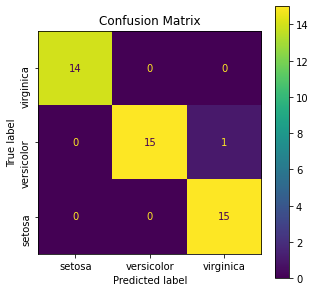

In [145]:
def TT_211(x, y, labels, k):
    trainTest = train_test(x, y, 0.7)
    neigh = K_neighbors_classifier(trainTest['TRAIN'][0], trainTest['TRAIN'][1], k)
    pred = neigh.predict(trainTest['TEST'][0])
    true = trainTest['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TT_211(data, target, iris["target_names"], 1)

### 2.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,0.916667
Precision,0.966667
F1-score,0.934837


,setosa,versicolor,virginica
setosa,2,0,0
versicolor,0,9,0
virginica,0,1,3


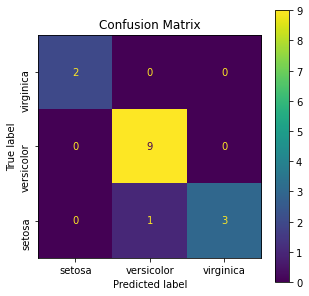

------------------- Iteração 1 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,9,0,0
versicolor,0,4,0
virginica,0,0,2


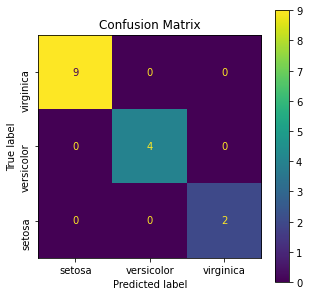

------------------- Iteração 2 -------------------


,Metrics
Recall,0.888889
Precision,0.944444
F1-score,0.903030


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,2,1
virginica,0,0,5


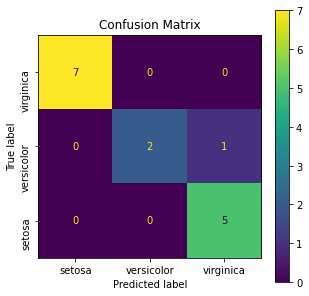

------------------- Iteração 3 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,4,0
virginica,0,0,5


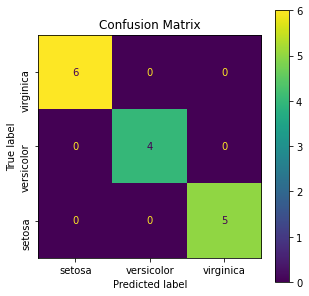

------------------- Iteração 4 -------------------


,Metrics
Recall,0.958333
Precision,0.933333
F1-score,0.940741


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,4,0
virginica,0,1,7


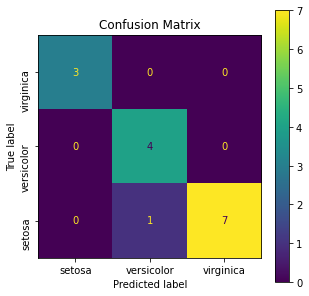

------------------- Iteração 5 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,0
virginica,0,0,4


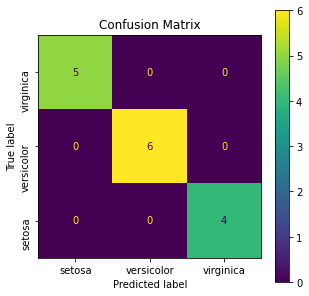

------------------- Iteração 6 -------------------


,Metrics
Recall,0.916667
Precision,0.966667
F1-score,0.934837


,setosa,versicolor,virginica
setosa,2,0,0
versicolor,0,3,1
virginica,0,0,9


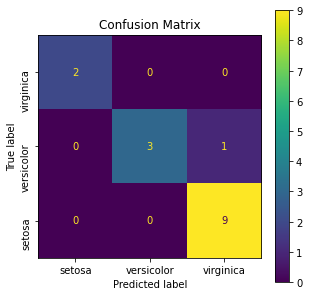

------------------- Iteração 7 -------------------


,Metrics
Recall,0.916667
Precision,0.952381
F1-score,0.926740


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,0
virginica,0,1,3


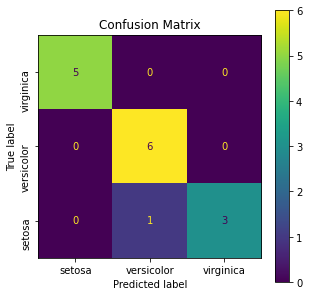

------------------- Iteração 8 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,3,0
virginica,0,0,5


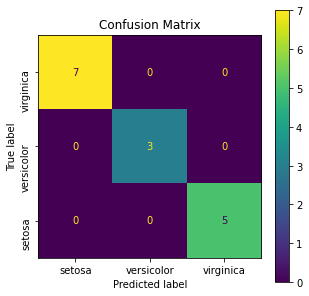

------------------- Iteração 9 -------------------


,Metrics
Recall,0.952381
Precision,0.933333
F1-score,0.937322


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,1
virginica,0,0,4


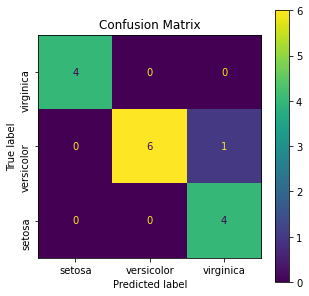

In [146]:
def CV_211(x, y, n_splits, labels, k):
    kf = k_fold(x, y, n_splits)

    count = 0
    for info in kf:
        print("------------------- Iteração " + str(count) + " -------------------")

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

        count += 1

CV_211(data, target, 10, iris["target_names"], 1)

### 2.1.2. k na gama {1, 3, 5, ...,15}

In [147]:
_k = np.arange(1, 16, 2)

display(_k)

array([ 1,  3,  5,  7,  9, 11, 13, 15])

### 2.1.2. Train-only

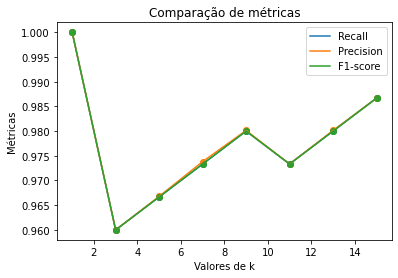

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


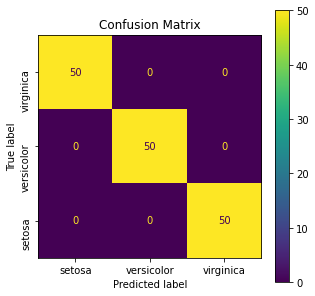

In [148]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TO_gama(x, y):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TO_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["Recall"].index(max(new_metr["Recall"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    neigh = K_neighbors_classifier(x, y, best_k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, iris["target_names"])

TO_gama(data, target)

### 2.1.2. TVT 40-30-30

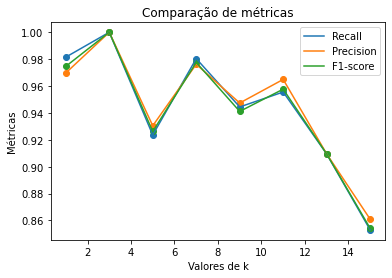

Best K: 3


,Metrics
Recall,0.974359
Precision,0.976190
F1-score,0.974321


,setosa,versicolor,virginica
setosa,19,0,0
versicolor,0,12,1
virginica,0,0,13


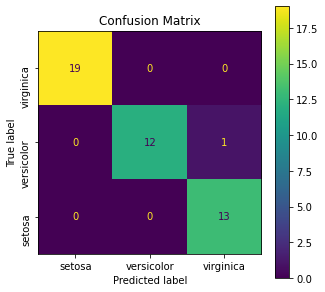

In [149]:
# TODO
# VER O MELHOR K -> FEITO
# PARA O MELHOR K, TESTAR COM O TREINO + VALIDATION JUNTOS, USANDO O TEST COMO PRED


def TVT_212(x, y, metr):
    for k in _k:
        trainValidation = train_validation_test(x, y, 0.4, 0.3)

        neigh = K_neighbors_classifier(trainValidation['TRAIN'][0], trainValidation['TRAIN'][1], k)
        pred = neigh.predict(trainValidation['VALIDATION'][0])
        true = trainValidation['VALIDATION'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TVT_gama(x, y):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TVT_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["Recall"].index(max(new_metr["Recall"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    newTrain0 = np.concatenate((trainValidation['TRAIN'][0], trainValidation['VALIDATION'][0]), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    pred = neigh.predict(trainValidation['TEST'][0])
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, iris["target_names"])

TVT_gama(data, target)

### 2.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


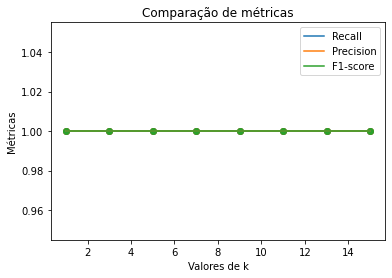

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,4,0
virginica,0,0,4


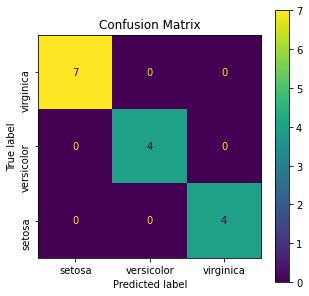

------------------- Iteração 1 -------------------


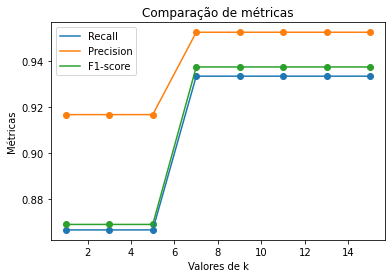

Best K: 7


,Metrics
Recall,0.933333
Precision,0.952381
F1-score,0.937322


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,0
virginica,0,1,4


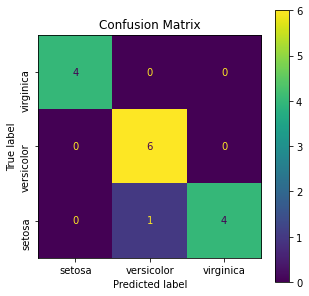

------------------- Iteração 2 -------------------


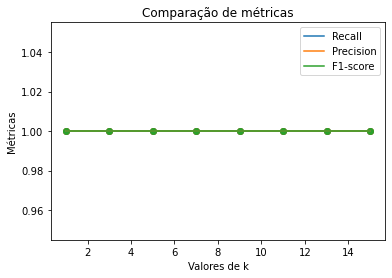

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,7,0
virginica,0,0,3


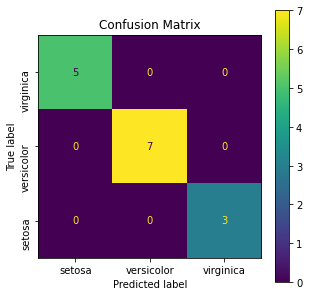

------------------- Iteração 3 -------------------


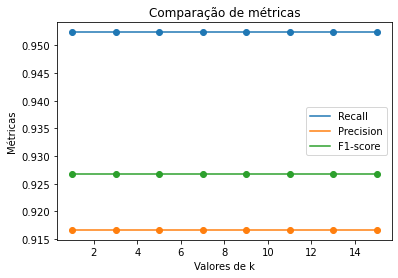

Best K: 1


,Metrics
Recall,0.952381
Precision,0.916667
F1-score,0.926740


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,1
virginica,0,0,3


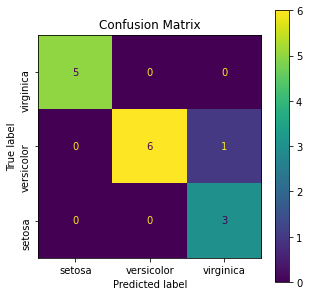

------------------- Iteração 4 -------------------


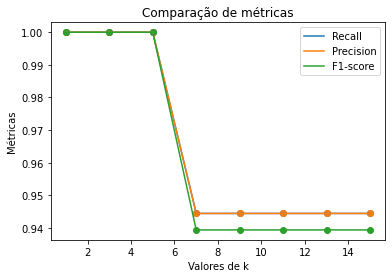

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,0
virginica,0,0,5


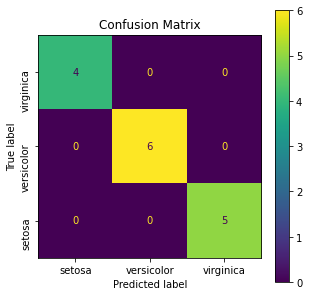

------------------- Iteração 5 -------------------


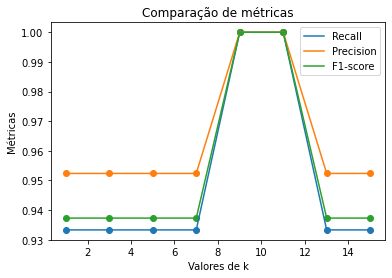

Best K: 9


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,0,6


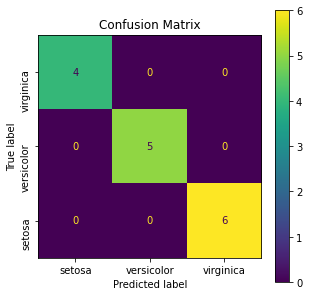

------------------- Iteração 6 -------------------


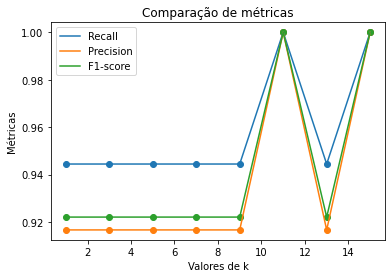

Best K: 11


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,6,0
virginica,0,0,3


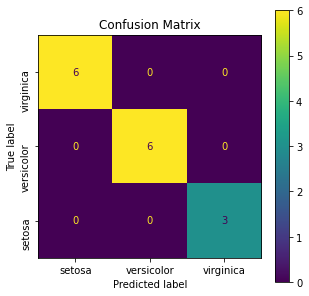

------------------- Iteração 7 -------------------


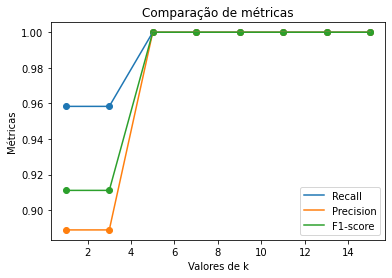

Best K: 5


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,2,0
virginica,0,0,8


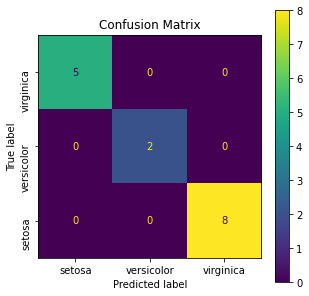

------------------- Iteração 8 -------------------


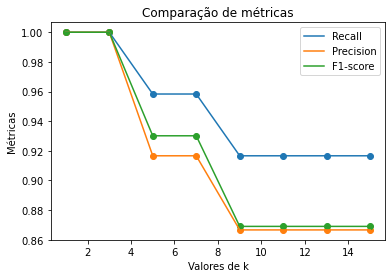

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,3,0
virginica,0,0,8


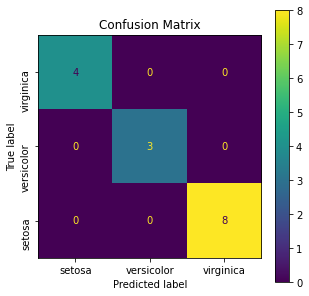

------------------- Iteração 9 -------------------


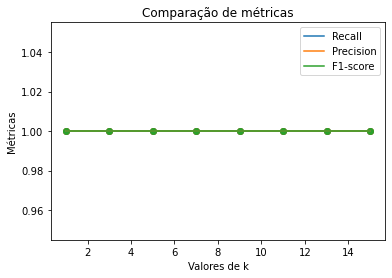

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,4,0
virginica,0,0,5


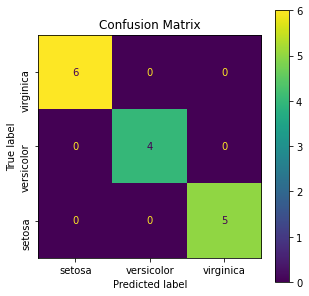

In [150]:
def CV_212(info, metr):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def CV_gama(x, y):
    
    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        new_metr = CV_212(info, metr)

        plot_metricas(new_metr)

        pos_k = new_metr["Recall"].index(max(new_metr["Recall"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], best_k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, iris["target_names"])

CV_gama(data, target)

### 2.2. ReliefF

In [151]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["F1-score"].append(f1)
    
    return metr


def repeatTO(x, y):
    rff = reliefF(x, y)
    f1_score = []

    for f in range(4):
        metr = {"F1-score": []}

        feat = rff[:(f+1)]
        new_metr = TO_212(x[:,feat], y, metr)

        f1_score.append(metr["F1-score"])

        #------------Plot F1-Score--------------------------
        plot_f1(new_metr)

        #------------Best k--------------------------
        print('Nr of features: ' + str(len(feat)))
        pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(x[:,feat], y, best_k)
        pred = neigh.predict(x[:,feat])
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        print('F1_score: ' + str(f1))
        print('-'*50)

    label = ['Nº of features: ' + str(i+1) for i in range(len(rff))]
    col = ['k=' + str(i) for i in _k]
    df = pd.DataFrame(f1_score, columns = col, index = label)
    display(df)

        
#repeatTO(data, target)

def CV_221(info, metr, feat):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0][:,feat], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0][:,feat])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["F1-score"].append(f1)

    #------------Plot F1-Score--------------------------
    plot_f1(metr)

    return metr


def repeatCV(x, y):
    rff = reliefF(x, y)

    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        f1_score = []
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        for f in range(4):

            metr = {"F1-score": []}
            feat = rff[:(f+1)]

            new_metr = CV_221(info, metr, feat)
            f1_score.append(new_metr["F1-score"])
            
            print('Nr of features: ' + str(len(feat)))
            pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
            best_k = _k[pos_k]
            print("Best K: " + str(best_k))

            neigh = K_neighbors_classifier(info['TRAIN'][0][:,feat], info['TRAIN'][1], best_k)
            pred = neigh.predict(info['TEST'][0][:,feat])
            true = info['TEST'][1]
            cm, rs, ps, f1 = metrics(true, pred)
            print('F1_score: ' + str(f1))
            print('-'*50)


        label = ['Nº of features: ' + str(i+1) for i in range(len(rff))]
        col = ['k=' + str(i) for i in _k]
        df = pd.DataFrame(f1_score, columns = col, index = label)
        display(df)
            

#repeatCV(data, target)

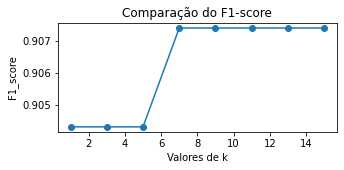

Nr of features: 1
Best K: 7
F1_score: 0.9751724137931035
--------------------------------------------------


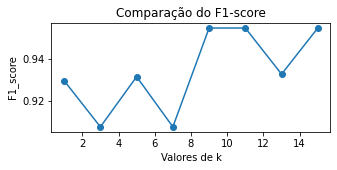

Nr of features: 2
Best K: 9
F1_score: 0.9751724137931035
--------------------------------------------------


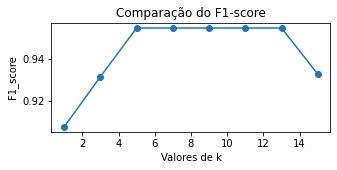

Nr of features: 3
Best K: 5
F1_score: 0.9751724137931035
--------------------------------------------------


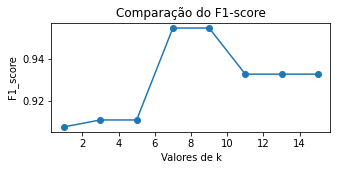

Nr of features: 4
Best K: 7
F1_score: 0.9751724137931035
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.904306,0.904306,0.904306,0.907407,0.907407,0.907407,0.907407,0.907407
Nº of features: 2,0.929495,0.907407,0.931429,0.907407,0.954751,0.954751,0.932660,0.954751
Nº of features: 3,0.907407,0.931429,0.954751,0.954751,0.954751,0.954751,0.954751,0.932660
Nº of features: 4,0.907407,0.910714,0.910714,0.954751,0.954751,0.932660,0.932660,0.932660


In [152]:
def plot_f1(metr_f1):
    plt.figure(figsize=(5,2))

    plt.plot(_k, metr_f1["F1-score"])
    plt.scatter(_k, metr_f1["F1-score"])
    
    plt.title("Comparação do F1-score")
    plt.xlabel("Valores de k")
    plt.ylabel("F1_score")
    plt.show()

def bestkTVT(metr, feat, xTrain, xValidation, trainValidation, s):
    s += 'Nr of features: ' + str(len(feat)) + '\n'
    print('Nr of features: ' + str(len(feat)))
    pos_k = metr["F1-score"].index(max(metr["F1-score"]))
    best_k = _k[pos_k]
    s += "Best K: " + str(best_k) + '\n'
    print("Best K: " + str(best_k))

    newTrain0 = np.concatenate((xTrain, xValidation), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    xTest = trainValidation['TEST'][0][:,feat]
    pred = neigh.predict(xTest)
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    s += 'F1_score: ' + str(f1) + '\n' + '-'*50 + '\n'
    print('F1_score: ' + str(f1))
    print('-'*50)

    return f1, s

def repeatTVT(x, y, featselec, num = 4):

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    f1_score = []
    f1_score_elbow = []
    str_print = ''

    for f in range(num):
        metr = {"F1-score": []}
        feat = featselec[:(f+1)]
        xTrain = trainValidation['TRAIN'][0][:,feat]
        xValidation = trainValidation['VALIDATION'][0][:,feat]

        for k in _k:
            neigh = K_neighbors_classifier(xTrain, trainValidation['TRAIN'][1], k)
            pred = neigh.predict(xValidation)
            true = trainValidation['VALIDATION'][1]
            cm, rs, ps, f1 = metrics(true, pred)

            metr["F1-score"].append(f1)
        f1_score.append(metr["F1-score"])

        #------------Plot F1-Score--------------------------
        plot_f1(metr)

        #------------Best k--------------------------
        aux, str_print = bestkTVT(metr, feat, xTrain, xValidation, trainValidation, str_print)
        f1_score_elbow.append(aux)

    label = ['Nº of features: ' + str(i+1) for i in range(len(featselec))]
    col = ['k=' + str(i) for i in _k]
    df = pd.DataFrame(f1_score, columns = col, index = label)
    display(df)

    return f1_score_elbow, df, str_print
        

f1_score_elbow, df223, str_print = repeatTVT(data, target, reliefF(data, target))

### 2.2.2 Elbow graph

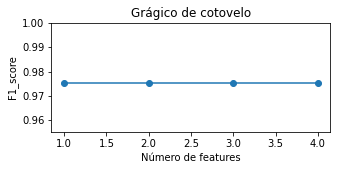

In [153]:
def elbowGraph(lista_f1, num):
    index = np.arange(1,num)

    plt.figure(figsize=(5,2))
    plt.ylim(min(lista_f1)-0.02,1)

    plt.plot(index, lista_f1)
    plt.scatter(index, lista_f1)
    
    plt.title("Grágico de cotovelo")
    plt.xlabel("Número de features")
    plt.ylabel("F1_score")
    plt.show()

elbowGraph(f1_score_elbow, 5)

### 2.2.3. Validation set results

In [154]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.904306,0.904306,0.904306,0.907407,0.907407,0.907407,0.907407,0.907407
Nº of features: 2,0.929495,0.907407,0.931429,0.907407,0.954751,0.954751,0.932660,0.954751
Nº of features: 3,0.907407,0.931429,0.954751,0.954751,0.954751,0.954751,0.954751,0.932660
Nº of features: 4,0.907407,0.910714,0.910714,0.954751,0.954751,0.932660,0.932660,0.932660


### 2.2.4. Test set results

In [155]:
print(str_print)

Nr of features: 1
Best K: 7
F1_score: 0.9751724137931035
--------------------------------------------------
Nr of features: 2
Best K: 9
F1_score: 0.9751724137931035
--------------------------------------------------
Nr of features: 3
Best K: 5
F1_score: 0.9751724137931035
--------------------------------------------------
Nr of features: 4
Best K: 7
F1_score: 0.9751724137931035
--------------------------------------------------



### 2.3. Fisher Score

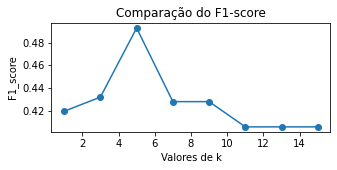

Nr of features: 1
Best K: 5
F1_score: 0.4740611691831204
--------------------------------------------------


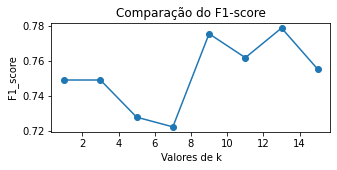

Nr of features: 2
Best K: 13
F1_score: 0.7936507936507936
--------------------------------------------------


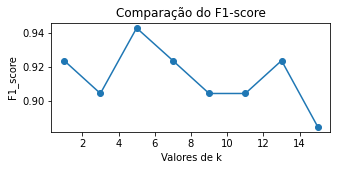

Nr of features: 3
Best K: 5
F1_score: 0.9743209876543211
--------------------------------------------------


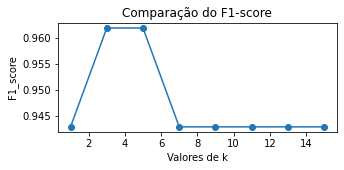

Nr of features: 4
Best K: 3
F1_score: 1.0
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.419839,0.432260,0.492674,0.428278,0.428278,0.406208,0.406208,0.406208
Nº of features: 2,0.749104,0.749104,0.727778,0.722222,0.775648,0.761905,0.778926,0.755245
Nº of features: 3,0.923747,0.904450,0.942857,0.923747,0.904450,0.904450,0.923747,0.884868
Nº of features: 4,0.942857,0.961874,0.961874,0.942857,0.942857,0.942857,0.942857,0.942857


In [156]:
score = fisherScore(data, target)

f1_score_elbow, df223, str_print = repeatTVT(data, target, score)


### 2.3.2. Elbow Graph

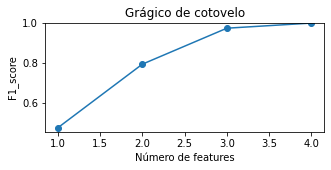

In [157]:
elbowGraph(f1_score_elbow, 5)

### 2.3.3. Validation set results

In [158]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.419839,0.432260,0.492674,0.428278,0.428278,0.406208,0.406208,0.406208
Nº of features: 2,0.749104,0.749104,0.727778,0.722222,0.775648,0.761905,0.778926,0.755245
Nº of features: 3,0.923747,0.904450,0.942857,0.923747,0.904450,0.904450,0.923747,0.884868
Nº of features: 4,0.942857,0.961874,0.961874,0.942857,0.942857,0.942857,0.942857,0.942857


### 2.3.4. Test set results

In [159]:
print(str_print)

Nr of features: 1
Best K: 5
F1_score: 0.4740611691831204
--------------------------------------------------
Nr of features: 2
Best K: 13
F1_score: 0.7936507936507936
--------------------------------------------------
Nr of features: 3
Best K: 5
F1_score: 0.9743209876543211
--------------------------------------------------
Nr of features: 4
Best K: 3
F1_score: 1.0
--------------------------------------------------



### 2.4. Class imbalance

 'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [160]:
irisDF = pd.DataFrame(iris.data, columns=iris["feature_names"])
irisDF["target"] = iris["target"]
setosa = irisDF[irisDF["target"] == 0]
versicolor = irisDF[irisDF["target"] == 1].sample(30)
virginica = irisDF[irisDF["target"] == 2].sample(10)
new_iris = pd.concat([setosa, versicolor, virginica], axis=0)
new_iris.groupby("target").count()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,50,50,50,50
1,30,30,30,30
2,10,10,10,10


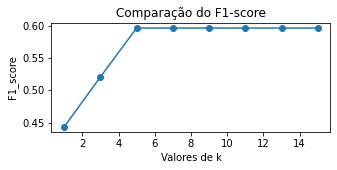

Nr of features: 1
Best K: 5
F1_score: 0.5277777777777777
--------------------------------------------------


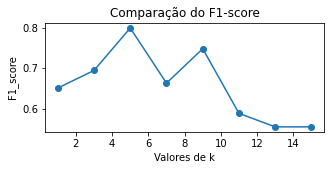

Nr of features: 2
Best K: 5
F1_score: 0.6638655462184874
--------------------------------------------------


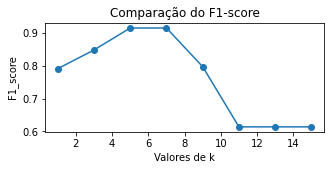

Nr of features: 3
Best K: 5
F1_score: 0.873015873015873
--------------------------------------------------


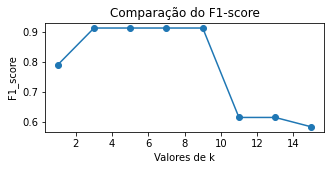

Nr of features: 4
Best K: 3
F1_score: 0.873015873015873
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.443250,0.520635,0.596429,0.596429,0.596429,0.596429,0.596429,0.596429
Nº of features: 2,0.650794,0.694444,0.799423,0.662932,0.748232,0.588235,0.554762,0.554762
Nº of features: 3,0.790476,0.847222,0.913725,0.913725,0.796296,0.614035,0.614035,0.614035
Nº of features: 4,0.790476,0.913725,0.913725,0.913725,0.913725,0.614035,0.614035,0.582492


In [161]:
aux_data = np.array(new_iris.drop(columns=["target"]))
aux_target = np.array(new_iris["target"])

score = fisherScore(aux_data, aux_target)

newIris_elbow, df224, str_print = repeatTVT(aux_data, aux_target, score)

### 2.4.2. Elbow Graph

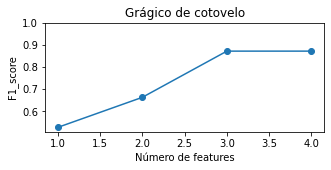

In [162]:
elbowGraph(newIris_elbow, 5)

### 2.4.3. Validation set results

In [163]:
display(df224)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.443250,0.520635,0.596429,0.596429,0.596429,0.596429,0.596429,0.596429
Nº of features: 2,0.650794,0.694444,0.799423,0.662932,0.748232,0.588235,0.554762,0.554762
Nº of features: 3,0.790476,0.847222,0.913725,0.913725,0.796296,0.614035,0.614035,0.614035
Nº of features: 4,0.790476,0.913725,0.913725,0.913725,0.913725,0.614035,0.614035,0.582492


### 2.4.4. Test set results

In [164]:
print(str_print)

Nr of features: 1
Best K: 5
F1_score: 0.5277777777777777
--------------------------------------------------
Nr of features: 2
Best K: 5
F1_score: 0.6638655462184874
--------------------------------------------------
Nr of features: 3
Best K: 5
F1_score: 0.873015873015873
--------------------------------------------------
Nr of features: 4
Best K: 3
F1_score: 0.873015873015873
--------------------------------------------------



### 3. ReliefF for dataset of human activity

In [165]:
path_parent = os.path.dirname(os.getcwd())
path = path_parent + '/Part_A/code'

Acc_features = pd.read_csv(path + "/Acc_features.csv").drop(columns='Unnamed: 0')
Gyr_features = pd.read_csv(path + "/Gyr_features.csv").drop(columns=['Unnamed: 0','Label'])
Mag_features = pd.read_csv(path + "/Mag_features.csv").drop(columns=['Unnamed: 0', 'Label'])

new_data = pd.concat([Acc_features, Gyr_features, Mag_features], axis=1)
new_data.to_csv('features.csv', encoding='utf-8')
display(new_data)

,Label,Acc X Mean,Acc X Median,Acc X Std,Acc X Variance,Acc X RMS,Acc X AD,Acc X Skew,Acc X Kurtosis,Acc X IQR,...,Mag Z acc Z Corr,Mag X gyr X Corr,Mag X gyr Y Corr,Mag X gyr Z Corr,Mag Y gyr X Corr,Mag Y gyr Y Corr,Mag Y gyr Z Corr,Mag Z gyr X Corr,Mag Z gyr Y Corr,Mag Z gyr Z Corr
0,Stand,2.816928,2.81290,0.081657,0.006668,2.818100,-0.000820,0.104070,0.486731,0.084675,...,0.538935,0.288415,-0.039466,-0.261845,0.319700,-0.137996,-0.320163,-0.608719,0.247963,0.599854
1,Stand,2.864813,2.86200,0.088376,0.007810,2.866162,0.001941,-0.237104,-0.098164,0.135050,...,0.844737,-0.477185,-0.213984,0.385307,-0.190807,-0.281080,0.065046,0.434173,0.272281,-0.243218
2,Stand,2.646591,2.80950,0.347139,0.120506,2.669039,-0.011722,-0.984057,-0.323593,0.464225,...,-0.773026,-0.399344,-0.234917,0.380753,0.428215,0.272995,-0.462982,0.414267,0.233638,-0.398286
3,Stand,2.212950,2.09150,0.285796,0.081679,2.231149,-0.008253,0.830326,-0.620484,0.455650,...,-0.662408,0.547276,0.405573,-0.486648,-0.267835,-0.202777,0.193784,-0.513572,-0.399738,0.459841
4,Stand,2.058188,2.05515,0.102485,0.010503,2.060713,0.001548,0.153356,0.366587,0.133325,...,0.120578,-0.024781,-0.101842,-0.099390,-0.099077,-0.049309,-0.077035,0.184977,0.288267,0.136665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14483,Climb stairs (up/down) and talk -> walk and talk,-2.100210,-2.19370,0.641578,0.411623,2.195101,-0.003014,0.470363,-0.706343,0.992650,...,-0.018973,0.118220,0.258170,-0.052384,0.068988,0.407538,0.036470,0.223724,-0.114251,0.030868
14484,Climb stairs (up/down) and talk -> walk and talk,3.425963,4.08130,1.693263,2.867140,3.817886,-0.035674,-1.723238,2.626517,1.417625,...,-0.726469,-0.551289,0.193614,0.176818,-0.063941,-0.482605,-0.523068,0.652333,-0.212316,-0.115947
14485,Climb stairs (up/down) and talk -> walk and talk,2.307871,2.18690,1.030087,1.061080,2.525261,0.024127,0.010703,0.621858,0.955350,...,0.189340,-0.394748,-0.056330,0.030090,0.067419,0.096801,0.058462,0.371020,0.462721,0.366293
14486,Climb stairs (up/down) and talk -> walk and talk,1.404052,1.36710,0.719179,0.517218,1.575915,0.010513,-0.280569,0.222744,0.997815,...,0.072190,0.190854,0.447516,0.256721,0.279052,0.443746,0.507358,-0.002371,-0.630569,-0.392307


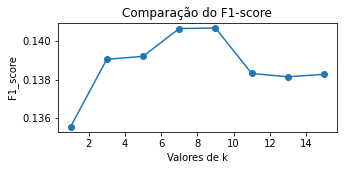

Nr of features: 1
Best K: 9
F1_score: 0.13909738907681396
--------------------------------------------------


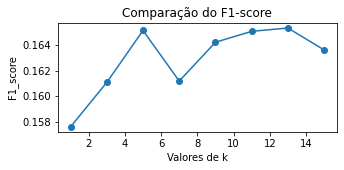

Nr of features: 2
Best K: 13
F1_score: 0.16013825542595514
--------------------------------------------------


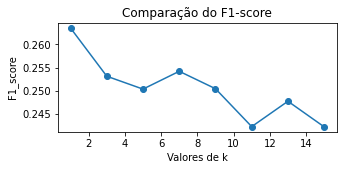

Nr of features: 3
Best K: 1
F1_score: 0.24669773356467015
--------------------------------------------------


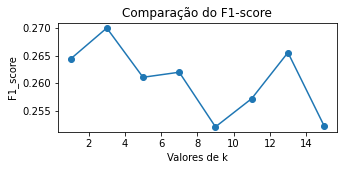

Nr of features: 4
Best K: 3
F1_score: 0.2600650462393322
--------------------------------------------------


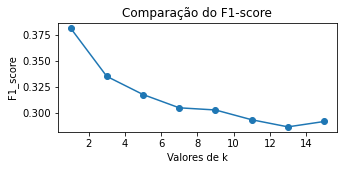

Nr of features: 5
Best K: 1
F1_score: 0.3810032460892615
--------------------------------------------------


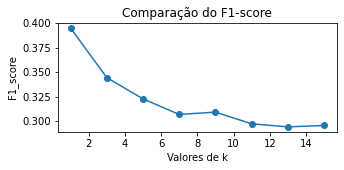

Nr of features: 6
Best K: 1
F1_score: 0.45590925577685526
--------------------------------------------------


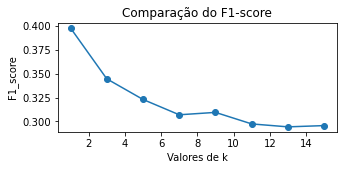

Nr of features: 7
Best K: 1
F1_score: 0.45606658943935924
--------------------------------------------------


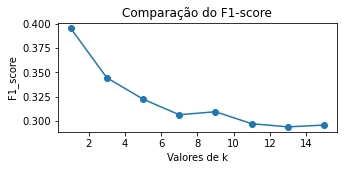

Nr of features: 8
Best K: 1
F1_score: 0.45530831235344016
--------------------------------------------------


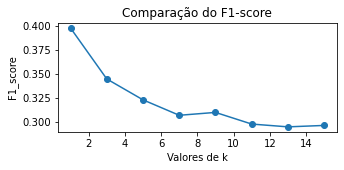

Nr of features: 9
Best K: 1
F1_score: 0.45628555082040845
--------------------------------------------------


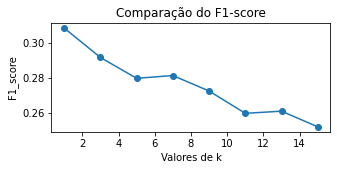

Nr of features: 10
Best K: 1
F1_score: 0.3324191341123057
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.135555,0.139059,0.139215,0.140657,0.140685,0.138325,0.138153,0.138283
Nº of features: 2,0.157622,0.161076,0.165114,0.161183,0.164201,0.165048,0.165306,0.163596
Nº of features: 3,0.263543,0.253129,0.250343,0.254195,0.250431,0.242238,0.247719,0.242187
Nº of features: 4,0.264412,0.270058,0.261084,0.262007,0.252053,0.257201,0.265591,0.252215
Nº of features: 5,0.381238,0.335137,0.317834,0.305149,0.303091,0.293765,0.286987,0.292105
Nº of features: 6,0.395261,0.344613,0.322941,0.307001,0.309397,0.297429,0.294349,0.295759
Nº of features: 7,0.397795,0.344627,0.323029,0.307001,0.309502,0.297435,0.294359,0.295677
Nº of features: 8,0.395501,0.344627,0.322717,0.306676,0.309759,0.297518,0.294277,0.296086
Nº of features: 9,0.397794,0.344614,0.322805,0.306676,0.309677,0.297518,0.294593,0.296085
Nº of features: 10,0.308521,0.291716,0.279817,0.281399,0.272553,0.259821,0.261053,0.252102


In [166]:
new_target = np.array(new_data["Label"])
feature_data = np.array(new_data.drop(columns = ["Label"]))
newActivity_elbow, df3, str_print = repeatTVT(feature_data,new_target, reliefF(feature_data, new_target), 10)

### 3.2. Elbow Graph

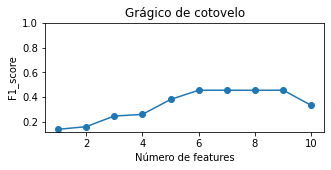

In [167]:
elbowGraph(newActivity_elbow, 11)

### 3.3. Validation set results

In [168]:
display(df3)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.135555,0.139059,0.139215,0.140657,0.140685,0.138325,0.138153,0.138283
Nº of features: 2,0.157622,0.161076,0.165114,0.161183,0.164201,0.165048,0.165306,0.163596
Nº of features: 3,0.263543,0.253129,0.250343,0.254195,0.250431,0.242238,0.247719,0.242187
Nº of features: 4,0.264412,0.270058,0.261084,0.262007,0.252053,0.257201,0.265591,0.252215
Nº of features: 5,0.381238,0.335137,0.317834,0.305149,0.303091,0.293765,0.286987,0.292105
Nº of features: 6,0.395261,0.344613,0.322941,0.307001,0.309397,0.297429,0.294349,0.295759
Nº of features: 7,0.397795,0.344627,0.323029,0.307001,0.309502,0.297435,0.294359,0.295677
Nº of features: 8,0.395501,0.344627,0.322717,0.306676,0.309759,0.297518,0.294277,0.296086
Nº of features: 9,0.397794,0.344614,0.322805,0.306676,0.309677,0.297518,0.294593,0.296085
Nº of features: 10,0.308521,0.291716,0.279817,0.281399,0.272553,0.259821,0.261053,0.252102


### 3.4. Test set results

In [169]:
print(str_print)

Nr of features: 1
Best K: 9
F1_score: 0.13909738907681396
--------------------------------------------------
Nr of features: 2
Best K: 13
F1_score: 0.16013825542595514
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.24669773356467015
--------------------------------------------------
Nr of features: 4
Best K: 3
F1_score: 0.2600650462393322
--------------------------------------------------
Nr of features: 5
Best K: 1
F1_score: 0.3810032460892615
--------------------------------------------------
Nr of features: 6
Best K: 1
F1_score: 0.45590925577685526
--------------------------------------------------
Nr of features: 7
Best K: 1
F1_score: 0.45606658943935924
--------------------------------------------------
Nr of features: 8
Best K: 1
F1_score: 0.45530831235344016
--------------------------------------------------
Nr of features: 9
Best K: 1
F1_score: 0.45628555082040845
--------------------------------------------------
Nr of features: 10
B